# AI-Powered YouTube Sentiment Scanner <a class="anchor" id="top-bullet"></a>

Victor B. S. Reis

Sep, 2024

## The Problem
- Small business owners, startups, and marketing teams are eager to understand how their products or services are being received in the market
- They wish for insights into customer opinions and trends, particularly on platforms like YouTube, to gauge performance and evaluate marketing KPIs
- Whether it's tracking product popularity or identifying sentiment, these businesses rely on real-time feedback to make data-driven decisions!

## Project Overview
This project aims to help users discover and analyze customer sentiment from Youtube video comments by:
- Searching for a given term, for example a product name
- Presenting the resulting video list from the research, while labeling each title as relevant or not
- Each video will have their comments analyzed based on their content
- Using NLP and AI, each comments will be classified under specific sentiment categories (Positive, Negative or Neutral)
- Presenting the sentiment analysis results via word clouds and brief descriptions that highlight key insights from the data

## Steps
- **Search for an expression/name (YouTube API):**
    - The YouTube Data API is used to retrieve a list of videos related to the search term
    - Python’s requests library interact with the API and parse the video metadata for further analysis
    
- **Classify Relevant Videos (ChatGPT/LLM Classification):**
    - Each video returned from the search is filtered by relevance using an LLM
    - Python’s openai library interacts with the LLM, where the video title and description are sent to classify whether the video is relevant or not (using a custom prompt).
    
- **Pre-process Comments:**
    - Once relevant videos are selected, the project uses the YouTube API to retrieve comments from each video.
    - Text preprocessing steps like tokenization, removal of stop words, and basic cleaning are performed using libraries like nltk or spacy.

- **Classify Sentiment (ChatGPT/LLM Sentiment Analysis):**
    - Comments from each video are passed to the LLM, which classifies the overall sentiment of each one as Positive, Neutral, or Negative.
    - This is accomplished by using the OpenAI library to communicate with the LLM, with a customizable prompt to reflect the video’s context.
    - Results are saved into a Pandas DataFrame for structured analysis.
    
- **Word Cloud Generation:**
    - The most frequent terms in positive and negative comments are visualized in a word cloud.
    - Python’s wordcloud library is used to create these visualizations, offering a quick overview of the most discussed terms.
    
- **Final Summary and Insights (Sentiment & Summary Generation):**
    - For each video, a brief summary is generated based on the most frequent sentiments and key opinions.
    - The LLM produces a concise description highlighting significant trends (e.g., “Most users love the product’s design but complain about its price”).
    - The overall sentiment rating is aggregated and visualized for user interpretation.


## Table of Contents:
* [Preparing Inputs](#second-bullet)
* [Pre-processing Comments](#third-bullet)
* [Classifying Sentiment](#fourth-bullet)
* [Deployment in Production](#fifth-bullet)
* [Results and Future Improvements](#sixth-bullet)

---

# Preparing Inputs<a class="anchor" id="second-bullet"></a>
The first step is to search for video results and classifying their relevance based on a search expression, like a product name.

### Imports

In [3]:
import pandas as pd
import numpy as np
import nltk
import emoji
import re
import requests
import os
from openai import OpenAI
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory
from googleapiclient.discovery import build

In [60]:
# keys 
api_key = ''
openai_key = ''

### Loading API and testing retrieval
First we try to initialize the youtube API based on the official documentation and return all the comments from a video based on its ID

In [49]:
def load_api(api_key):
    # Set up the API
    youtube = build('youtube', 'v3', developerKey=api_key)
    return youtube

# Fetch comments
youtube = load_api(api_key)

In [10]:
# Example usage
video_id = 'i1GXJFH8xm4'

# make a request for the comment threads
comments = []
comments_request = youtube.commentThreads().list(
    part="snippet",
    videoId=video_id,
    maxResults=100
)
response = comments_request.execute()

# make a request for video info
video_request = youtube.videos().list(
        part="snippet",
        id=video_id
    )
video_response = video_request.execute()

In [11]:
video_response

{'kind': 'youtube#videoListResponse',
 'etag': '0vp-SAtkppYc4kFLUa634H0a08E',
 'items': [{'kind': 'youtube#video',
   'etag': 'm5A9pAdnQQb7MzByQNXs9dr05D4',
   'id': 'i1GXJFH8xm4',
   'snippet': {'publishedAt': '2024-09-03T14:45:04Z',
    'channelId': 'UCtaDOcil7AXjT28K0mW7UQA',
    'title': 'COMO EXIBIR IMAGENS DA COLUNA DE IMAGEM DO SHAREPOINT LIST ONLINE NO POWER BI PASSO A PASSO',
    'description': 'Aprenda passo a passo como exibir imagens da coluna de imagem do sharepoint list online direto no power bi.\n\nConheça nossos cursos e nos apoie!\nhttps://ead.vicotreinamentos.com.br\n\n00:00 Introdução , conectando sharepoint list ao power bi passo a passo v1 e v2\n02:46 Como chegar na URL da imagem da coluna da lista.\n04:35 Criando coluna calculada com a URL para obter imagem da coluna\n06:35 Criando função para obter dados da URL.\n08:50 Parte mais importante .\n\n--\n\n📚 GRUPO DE ESTUDOS E DUVIDAS GRATUITO\n- Telegram: https://vicotreinamentos.com.br/GrupoEstudoGratis\n\n🔽 SE CONE

### Search for video results

After obtaining a good understanding on how the data from a video is returned from the API, now we create a function to search for multiple videos based on a search expression:

In [12]:
def search_videos(search_query, api_key):
    max_results = 10  # Number of videos to retrieve
    API_KEY = api_key

    url = f"https://www.googleapis.com/youtube/v3/search?part=snippet&maxResults={max_results}&q={search_query}&type=video&key={API_KEY}"

    response = requests.get(url)
    data = response.json()

    # Extract video IDs and URLs
    video_data = []
    for item in data['items']:
        video_id = item['id']['videoId']
        video_title = item['snippet']['title']
        video_description = item['snippet']['description']
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        
        # append to the list
        video_data.append({
            'video_id': video_id,
            'video_title': video_title,
            'video_description': video_description,
            'video_url': video_url
        })
        
    return pd.DataFrame(video_data)

In [13]:
# quick test
df_videos = search_videos("Ray-Ban Meta Smart Glasses", api_key)
display(df_videos)

,video_id,video_title,video_description,video_url
0,E1LW_MteTho,Introducing the Ray-Ban Meta Smart Glasses Col...,Meet the next generation of smart glasses. The...,https://www.youtube.com/watch?v=E1LW_MteTho
1,ViA4-YWx8Y4,Meta Ray-Ban Smart Glasses Review - 6 Months L...,Have the Meta Ray-Ban Smart Glasses been worth...,https://www.youtube.com/watch?v=ViA4-YWx8Y4
2,pgiWqkvIclk,The Ray-Ban Meta Smart Glasses are a turning p...,"Smart glasses have always been a hard sell, bu...",https://www.youtube.com/watch?v=pgiWqkvIclk
3,utSc7DxIvTU,RayBan Meta SMART GLASSES Review and MY HUGE M...,I made a HUGE mistake when ordering the RayBan...,https://www.youtube.com/watch?v=utSc7DxIvTU
4,gY9cP2ZWfVI,Ray-Ban Meta smart glasses hands-on: Techy sun...,Meta has almost completely revamped its high-t...,https://www.youtube.com/watch?v=gY9cP2ZWfVI
5,ykj-ZQDrgYA,What Ray-Ban Meta Smart Glasses Are ACTUALLY Like,Ray-Ban Meta https://geni.us/jZMqUE The mic I ...,https://www.youtube.com/watch?v=ykj-ZQDrgYA
6,ct6f28FL8s8,COOLEST AI smart glasses are ever🤯#raybanmeta,This is Called the meta rayban glasses that ar...,https://www.youtube.com/watch?v=ct6f28FL8s8
7,yj9_lRvbbNU,Rayban Meta Smart Glasses cannot secretly reco...,,https://www.youtube.com/watch?v=yj9_lRvbbNU
8,iivBLI8ml6o,"Anderson .Paak, Tinashe, and James Blake exper...","AndersonPaak, @tinashenow, and @jamesblake are...",https://www.youtube.com/watch?v=iivBLI8ml6o
9,_PhGQLIztog,Why I RETURNED the Ray Ban Meta Smart Glasses ...,The Ray Ban Meta smart glasses have a tiny cam...,https://www.youtube.com/watch?v=_PhGQLIztog


### Evaluating relevance with AI

With the video list, maybe not all of them will contain relevant info or relevant comments for our purpose. We need a way to quickly determine which videos will be relevant or not to the analysis. For this, a LLM will be used, and for a matter of simplicity and cost at this moment OpenAI's API is a good choice, and GPT 3.5 should suffice.

This was thought more as an optional step in order to allow the user double check which videos are about to be analysed and make sure none of them are unrelated to the desired topic, avoiding contamination of the upcoming sentiment analysis.

In [14]:
# function to classify video title as relevant or not for our search
def classify_video(search_query, df_videos, api_key):
    # prompt
    prompt_sistema = f"""You are a marketing analyst skilled in evaluating the relevance of videos for product or topic analysis.
    Given a video title and description, determine if the content is RELEVANT or NOT RELEVANT based on its value for marketing 
    insights, research purposes, or general audience interest. Consider aspects such as alignment with the search term or 
    expression, potential to engage or inform the target audience, and contribution to a comprehensive understanding of the 
    topic. Your goal is to help filtering those videos so stakeholders can understand how their products or services are being 
    received in the market. You will receive a "search_string" for a product or topic that will be researched, as well as a 
    video title and its description. You should analyze each one of them and return only a single string with one of the options:
    ["RELEVANT","NOT RELEVANT"]
    """
    # initialize client
    cliente = OpenAI(api_key=api_key)
    
    # iterate every dataframe row
    for _,item in df_videos.iterrows():
        prompt_user = f"Search query: {search_query}\nVideo title: {item['video_title']}\nVideo description: {item['video_description']}"

        response = cliente.chat.completions.create(
            messages = [
                {
                    "role":"system",
                    "content":prompt_sistema
                },
                {
                    "role":"user",
                    "content":prompt_user
                }
            ],
            model="gpt-3.5-turbo",
            max_tokens=10
        )

        result = response.choices[0].message.content
        df_videos['relevance'] = result
        
        
    return df_videos

In [15]:
# quick test
classify_video("Ray-Ban Meta Smart Glasses", df_videos, openai_key)

,video_id,video_title,video_description,video_url,relevance
0,E1LW_MteTho,Introducing the Ray-Ban Meta Smart Glasses Col...,Meet the next generation of smart glasses. The...,https://www.youtube.com/watch?v=E1LW_MteTho,NOT RELEVANT
1,ViA4-YWx8Y4,Meta Ray-Ban Smart Glasses Review - 6 Months L...,Have the Meta Ray-Ban Smart Glasses been worth...,https://www.youtube.com/watch?v=ViA4-YWx8Y4,NOT RELEVANT
2,pgiWqkvIclk,The Ray-Ban Meta Smart Glasses are a turning p...,"Smart glasses have always been a hard sell, bu...",https://www.youtube.com/watch?v=pgiWqkvIclk,NOT RELEVANT
3,utSc7DxIvTU,RayBan Meta SMART GLASSES Review and MY HUGE M...,I made a HUGE mistake when ordering the RayBan...,https://www.youtube.com/watch?v=utSc7DxIvTU,NOT RELEVANT
4,gY9cP2ZWfVI,Ray-Ban Meta smart glasses hands-on: Techy sun...,Meta has almost completely revamped its high-t...,https://www.youtube.com/watch?v=gY9cP2ZWfVI,NOT RELEVANT
5,ykj-ZQDrgYA,What Ray-Ban Meta Smart Glasses Are ACTUALLY Like,Ray-Ban Meta https://geni.us/jZMqUE The mic I ...,https://www.youtube.com/watch?v=ykj-ZQDrgYA,NOT RELEVANT
6,ct6f28FL8s8,COOLEST AI smart glasses are ever🤯#raybanmeta,This is Called the meta rayban glasses that ar...,https://www.youtube.com/watch?v=ct6f28FL8s8,NOT RELEVANT
7,yj9_lRvbbNU,Rayban Meta Smart Glasses cannot secretly reco...,,https://www.youtube.com/watch?v=yj9_lRvbbNU,NOT RELEVANT
8,iivBLI8ml6o,"Anderson .Paak, Tinashe, and James Blake exper...","AndersonPaak, @tinashenow, and @jamesblake are...",https://www.youtube.com/watch?v=iivBLI8ml6o,NOT RELEVANT
9,_PhGQLIztog,Why I RETURNED the Ray Ban Meta Smart Glasses ...,The Ray Ban Meta smart glasses have a tiny cam...,https://www.youtube.com/watch?v=_PhGQLIztog,NOT RELEVANT


### Adding more videos

We also want the user to add new video URLs aside from those if they want to, so we make another function for that:

In [16]:
def add_videos(video_url, df_videos, api_key):
    API_KEY = api_key
    
     # extract the video ID from the URL
    video_id = video_url.split('v=')[-1] 
    
    url = f"https://www.googleapis.com/youtube/v3/videos?id={video_id}&part=snippet&key={API_KEY}"

    response = requests.get(url)
    data = response.json()
    
    # Extract the necessary details
    video_title = data['items'][0]['snippet']['title']
    video_description = data['items'][0]['snippet']['description']
    
    # Append the new video information to the DataFrame
    new_row = {
        'video_id': video_id,
        'video_title': video_title,
        'video_description': video_description,
        'video_url': video_url
    }
    new_df = pd.DataFrame([new_row])
    df_videos = pd.concat([df_videos, new_df], axis=0, ignore_index=True)

    return df_videos

In [17]:
# Testing everything together

# search for a product
search_query = "nike air review"
df_videos = search_videos(search_query, api_key)
display(df_videos)

# evaluate relevance
df_videos = classify_video(search_query, df_videos, openai_key)
display(df_videos)

# add new URLs:
df_videos = add_videos("https://www.youtube.com/watch?v=hb0j9Qn-KjM", df_videos, api_key)
df_videos = add_videos("https://www.youtube.com/watch?v=M-XfdqPBAMU", df_videos, api_key)
display(df_videos)

,video_id,video_title,video_description,video_url
0,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",https://www.youtube.com/watch?v=8y5-UvxoD2E
1,5JzIrzXV2vI,Pros &amp; Cons: 2024 Nike Air Max DN Review!,Shop Hibbett City Gear Here! https://bit.ly/37...,https://www.youtube.com/watch?v=5JzIrzXV2vI
2,p_-2u8x4Re0,Nike Alphafly Next % 2 Shoe Review,,https://www.youtube.com/watch?v=p_-2u8x4Re0
3,P2YQHLY8TGw,Nike Air Max 270 Review Black and White,The Nike Air Max 270 was originally released i...,https://www.youtube.com/watch?v=P2YQHLY8TGw
4,xGM6g7HTInU,Nike Air More Uptempo Low,Shop POIZON here!! #ad #poizon Use my code [TE...,https://www.youtube.com/watch?v=xGM6g7HTInU
5,xxrXtdVyn34,Nike Doesn&#39;t Know What&#39;s Inside Their ...,Buy some Rose anvil leather goods that EVERYBO...,https://www.youtube.com/watch?v=xxrXtdVyn34
6,4iv34wHa8Jk,Nike Air Max 97 White Review: Not What I Expec...,"Description In this video, we review the Air M...",https://www.youtube.com/watch?v=4iv34wHa8Jk
7,K-HoJUGc4XM,Nike Air Deldon Biggest Pros And Cons ( Perfor...,Grab a pair at Nike: https://geni.us/deldon FR...,https://www.youtube.com/watch?v=K-HoJUGc4XM
8,X1ayLlbBtrg,Nike Jordan 3 Retro Cement Grey | Unboxing &am...,,https://www.youtube.com/watch?v=X1ayLlbBtrg
9,wKEF7-LNhSo,BEST AIR MAX UNDER £100!? Nike Air Max &quot;S...,Nike Air Max SYSTM DM9537-001 https://tidd.ly/...,https://www.youtube.com/watch?v=wKEF7-LNhSo


,video_id,video_title,video_description,video_url,relevance
0,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",https://www.youtube.com/watch?v=8y5-UvxoD2E,RELEVANT
1,5JzIrzXV2vI,Pros &amp; Cons: 2024 Nike Air Max DN Review!,Shop Hibbett City Gear Here! https://bit.ly/37...,https://www.youtube.com/watch?v=5JzIrzXV2vI,RELEVANT
2,p_-2u8x4Re0,Nike Alphafly Next % 2 Shoe Review,,https://www.youtube.com/watch?v=p_-2u8x4Re0,RELEVANT
3,P2YQHLY8TGw,Nike Air Max 270 Review Black and White,The Nike Air Max 270 was originally released i...,https://www.youtube.com/watch?v=P2YQHLY8TGw,RELEVANT
4,xGM6g7HTInU,Nike Air More Uptempo Low,Shop POIZON here!! #ad #poizon Use my code [TE...,https://www.youtube.com/watch?v=xGM6g7HTInU,RELEVANT
5,xxrXtdVyn34,Nike Doesn&#39;t Know What&#39;s Inside Their ...,Buy some Rose anvil leather goods that EVERYBO...,https://www.youtube.com/watch?v=xxrXtdVyn34,RELEVANT
6,4iv34wHa8Jk,Nike Air Max 97 White Review: Not What I Expec...,"Description In this video, we review the Air M...",https://www.youtube.com/watch?v=4iv34wHa8Jk,RELEVANT
7,K-HoJUGc4XM,Nike Air Deldon Biggest Pros And Cons ( Perfor...,Grab a pair at Nike: https://geni.us/deldon FR...,https://www.youtube.com/watch?v=K-HoJUGc4XM,RELEVANT
8,X1ayLlbBtrg,Nike Jordan 3 Retro Cement Grey | Unboxing &am...,,https://www.youtube.com/watch?v=X1ayLlbBtrg,RELEVANT
9,wKEF7-LNhSo,BEST AIR MAX UNDER £100!? Nike Air Max &quot;S...,Nike Air Max SYSTM DM9537-001 https://tidd.ly/...,https://www.youtube.com/watch?v=wKEF7-LNhSo,RELEVANT


,video_id,video_title,video_description,video_url,relevance
0,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",https://www.youtube.com/watch?v=8y5-UvxoD2E,RELEVANT
1,5JzIrzXV2vI,Pros &amp; Cons: 2024 Nike Air Max DN Review!,Shop Hibbett City Gear Here! https://bit.ly/37...,https://www.youtube.com/watch?v=5JzIrzXV2vI,RELEVANT
2,p_-2u8x4Re0,Nike Alphafly Next % 2 Shoe Review,,https://www.youtube.com/watch?v=p_-2u8x4Re0,RELEVANT
3,P2YQHLY8TGw,Nike Air Max 270 Review Black and White,The Nike Air Max 270 was originally released i...,https://www.youtube.com/watch?v=P2YQHLY8TGw,RELEVANT
4,xGM6g7HTInU,Nike Air More Uptempo Low,Shop POIZON here!! #ad #poizon Use my code [TE...,https://www.youtube.com/watch?v=xGM6g7HTInU,RELEVANT
5,xxrXtdVyn34,Nike Doesn&#39;t Know What&#39;s Inside Their ...,Buy some Rose anvil leather goods that EVERYBO...,https://www.youtube.com/watch?v=xxrXtdVyn34,RELEVANT
6,4iv34wHa8Jk,Nike Air Max 97 White Review: Not What I Expec...,"Description In this video, we review the Air M...",https://www.youtube.com/watch?v=4iv34wHa8Jk,RELEVANT
7,K-HoJUGc4XM,Nike Air Deldon Biggest Pros And Cons ( Perfor...,Grab a pair at Nike: https://geni.us/deldon FR...,https://www.youtube.com/watch?v=K-HoJUGc4XM,RELEVANT
8,X1ayLlbBtrg,Nike Jordan 3 Retro Cement Grey | Unboxing &am...,,https://www.youtube.com/watch?v=X1ayLlbBtrg,RELEVANT
9,wKEF7-LNhSo,BEST AIR MAX UNDER £100!? Nike Air Max &quot;S...,Nike Air Max SYSTM DM9537-001 https://tidd.ly/...,https://www.youtube.com/watch?v=wKEF7-LNhSo,RELEVANT


# Pre-processing Comments<a class="anchor" id="third-bullet"></a>

In this step, I made a function that reads comments from a video and save them as a list of dicts:

In [18]:
def get_comments(video_id):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100000
    )
    response = request.execute()

    # creating a list
    comments = []
    for item in response['items']:
        comment = {} # and a dict to store the results
        comment['video_id'] = item['snippet']['videoId']
        comment['channel_id'] = item['snippet']['channelId']
        comment['author_name'] = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
        comment['author_channel_id'] = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
        comment['like_count'] = item['snippet']['topLevelComment']['snippet']['likeCount']
        comment['total_reply_count'] = item['snippet']['totalReplyCount']
        comment['published'] = item['snippet']['topLevelComment']['snippet']['publishedAt']
        comment['updated'] = item['snippet']['topLevelComment']['snippet']['updatedAt']
        comment['text_display'] = item['snippet']['topLevelComment']['snippet']['textDisplay']
        comment['is_op'] = 1 if comment['author_channel_id']==comment['channel_id'] else 0
        comments.append(comment)

    return comments

In [19]:
# testing the function
video_id = '0hwCp1TSHAQ'
get_comments(video_id)[1]

{'video_id': '0hwCp1TSHAQ',
 'channel_id': 'UCw0leRmeaX7R_9BDd3TvCzg',
 'author_name': '@procuradehorizontes',
 'author_channel_id': 'UCAqFlxxVe6EvYloBZYOMU1Q',
 'like_count': 0,
 'total_reply_count': 0,
 'published': '2024-10-05T21:42:00Z',
 'updated': '2024-10-05T21:42:00Z',
 'text_display': 'cara, muito obrigado. Muito fácil e simples.',
 'is_op': 0}

Now, we should decide which data fields we are going to work with. In principle, considering our main goals, the following fields seems to be enough:
- **ID:** video ID
- **Channel ID:** useful to compare with the 'Author Channel ID'
- **Author name:** can be used as an identifyer for each user, as well as the 'Author Channel ID'. One of them might be discarded later
- **Author channel ID:** can also be used as an unique user identifyer
- **Like count:** useful to map which comments are the most relevant or popular
- **Reply count:** also can be used to measure the comment's level of popularity
- **Published:** can be used to perform an analysis of comment publishing over time
- **Updated:** can be used as a real timestamp for the comment's content. For instance if a comment is originally negative and then the user changes it's content drastically, the code will read and consider the new content along with this new date, instead of the original published date.
- **Text Display:** the main content, which will be the scope of our analysis

The Channel ID refers to the uploader's channel, and the Author Channel ID is from the user that made the comment. So if they are the same, it means the comment is from the uploader/owner of the video. This might be useful if we want to consider them into our analysis or not!

In order for us to build and test our NLP pre-processing pipeline, let's use the previously obtained dataframe 'df_videos'

In [20]:
# obtain comments for each of the videos and save in a dataframe
def get_video_comments(df_videos):
    all_video_details = []

    for index, row in df_videos.iterrows():
        video_id = row['video_id']
        video_relevance = row['relevance']
        
        if video_relevance != "NOT RELEVANT":
            comments = get_comments(video_id)

            # append the video's details along with comments to the list
            for comment in comments:
                all_video_details.append({
                    'video_id': row['video_id'],
                    'video_title': row['video_title'],
                    'video_description': row['video_description'],
                    'video_relevance': video_relevance,
                    'text_display': comment['text_display'],
                    'channel_id': comment['channel_id'],
                    'author_name': comment['author_name'],
                    'author_channel_id': comment['author_channel_id'],
                    'like_count': comment['like_count'],
                    'total_reply_count': comment['total_reply_count'],
                    'published': comment['published'],
                    'updated': comment['updated'],
                    'published': comment['published'],
                    'is_op': comment['is_op']
                })
                
    df_videos_comments = pd.DataFrame(all_video_details)
    
    return df_videos_comments

df_videos_comments = get_video_comments(df_videos)


In [21]:
df_videos_comments

,video_id,video_title,video_description,video_relevance,text_display,channel_id,author_name,author_channel_id,like_count,total_reply_count,published,updated,is_op
0,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",RELEVANT,"If you’re ever injured in an accident, you can...",UCId9g4zlQ9BOn6fLKIt1Y0A,@RoseAnvil,UCId9g4zlQ9BOn6fLKIt1Y0A,33,7,2023-06-30T20:26:50Z,2023-06-30T20:26:50Z,1
1,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",RELEVANT,&quot;hotrods&quot; don&#39;t have the engine ...,UCId9g4zlQ9BOn6fLKIt1Y0A,@bennywolf2169,UCU2xViJic33PhfJVezQLOgw,0,0,2024-10-15T23:00:26Z,2024-10-15T23:00:26Z,0
2,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",RELEVANT,former air max 270 owner here (the sole just r...,UCId9g4zlQ9BOn6fLKIt1Y0A,@tatumvp0,UCBaeLavviiBLlPOOri5TXsg,0,0,2024-10-12T07:28:46Z,2024-10-12T07:28:46Z,0
3,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",RELEVANT,Personally the modern athletic shoe( Nike and ...,UCId9g4zlQ9BOn6fLKIt1Y0A,@Dukeofmamucas,UC15XHBYm-k7Ol7bEafuLRig,0,0,2024-10-10T17:50:16Z,2024-10-10T17:50:16Z,0
4,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",RELEVANT,They nice shoes but I use to wear mines for se...,UCId9g4zlQ9BOn6fLKIt1Y0A,@markjuarbe1048,UCwuPHypXuIlJlzzR3YV-ONQ,0,0,2024-10-09T00:04:15Z,2024-10-09T00:04:15Z,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,M-XfdqPBAMU,HUAWEI Mate XT Hands-on & Quick Review: Huawei...,That's my dream foldable phone right now.\n#hu...,NaN,Watching with my Samsung s20 ultra 😂 next upgr...,UC_alSLqNTLW624x66BLgkHg,@jesusloveyou9523,UC3fTPEUTT_z6oRbQrkZiTKw,0,0,2024-09-17T16:37:03Z,2024-09-17T16:37:03Z,0
950,M-XfdqPBAMU,HUAWEI Mate XT Hands-on & Quick Review: Huawei...,That's my dream foldable phone right now.\n#hu...,NaN,F Apple with BS marketing !,UC_alSLqNTLW624x66BLgkHg,@joekerr8037,UCrsKd9xCjAVAhM6ps1P6EFA,0,0,2024-09-17T15:19:28Z,2024-09-17T15:19:28Z,0
951,M-XfdqPBAMU,HUAWEI Mate XT Hands-on & Quick Review: Huawei...,That's my dream foldable phone right now.\n#hu...,NaN,Now imagine the US didn&#39;t sanction Huawei....,UC_alSLqNTLW624x66BLgkHg,@xxBlackpspxx,UCWomqdo5j4hLbqz22on3vYg,0,0,2024-09-17T14:49:12Z,2024-09-17T14:49:12Z,0
952,M-XfdqPBAMU,HUAWEI Mate XT Hands-on & Quick Review: Huawei...,That's my dream foldable phone right now.\n#hu...,NaN,There is a huge gap between some &quot; materi...,UC_alSLqNTLW624x66BLgkHg,@向日葵向日葵-c4v,UCd4Cmtp0-wSQ0ihhxyicAug,0,0,2024-09-17T14:08:34Z,2024-09-17T14:08:34Z,0


Now the **text_display** column contains all our data to be analyzed, but in order for a wordcloud to be created from them, this data shall be pre-processed so the comments are clean and in a format that is easier to be used by models and other functions.

First, in our pre-processing, we shall determine what actions should be done and in which order to obtain the best results.

From previous experiences in other projects, in this pre-processing pipeline the following steps should make the most sense:
- Remove numbers
- Remove mentions (contains @)
- Remove links
- Demojize (convert emoji into words with their meaning)
- Standardization of the most common keyboard emoticons
- Remove special characters
- Convert all text to lowercase
- Standardize common slangs/expressions
- Removal of characters that repeat 3 or more times within a single comment
- Tokenize (splitting the string into tokens - the smallest string blocks that can be considered)
- Stopwords removal
- Lemmatization (convert words into their "root" form - variations of the same are grouped up)

We shall import the 'nltk' (Natural Language Toolkit) lib, which includes tools for text processing, classification, tokenization, stemming, and much more... as well as 'emoji' lib, 're' (regex), and 'unidecode' to treat accentuation.

In [22]:
#nltk.download('stopwords')
#nltk.download('punkt_tab')
#nltk.download('wordnet')

In [23]:
# stopwords are a pre-defined collection of words that generally don't add any significant semantic meaning to text,
# so it's a common practice to remove them

stopwords = nltk.corpus.stopwords.words('english')
stopwords = list(set([unidecode(word) for word in stopwords])) # remove accentuation

lemmatizer = WordNetLemmatizer()

print(stopwords)

["didn't", 'for', 'having', 'couldn', 'these', 'if', 'under', 'own', 'very', 'i', 'have', "you'll", 'into', 'shouldn', 'until', 'most', "that'll", 'or', 'about', "it's", 'are', 'all', 'of', 'few', "haven't", 'it', "she's", 'your', 'too', 'by', 'each', 'aren', 'against', 'that', 'hers', 'shan', "don't", 'above', 'on', 'themselves', 'mightn', 'a', "needn't", 'once', "weren't", 'itself', 'our', "you're", "shan't", 'be', 'through', 'he', 'some', "hasn't", 'then', "hadn't", 'when', 'weren', 'them', 'than', 'won', 'same', 'did', 'was', "shouldn't", 'there', 'we', "mustn't", 'down', 'only', 'where', "couldn't", 'him', 'between', 'yours', 'me', 'out', 'himself', 'whom', 'should', 'with', 'haven', 'but', 'they', 'is', 'the', 'as', 'such', 'being', 'here', 'ain', 'yourselves', 'after', 'more', 'my', 've', 'no', 'so', 're', 'isn', 'do', "aren't", 'because', 'were', 'doing', 'ma', 'her', 'what', 'yourself', 'while', 'further', 'nor', "won't", 'before', 'o', "wasn't", 'hasn', 'doesn', 'needn', 'and

After some testing with the code below, I noticed two things: first, that there are some candidates for stopwords that weren't considered in the original list but they could be included. Second, some comments are in different languages other than English, and that surely needs to be dealt with in order for our pre-processing pipeline and LLM mdoel to work properly.

So we shall use another lib to identify the language, and only English will be considered at this time because otherwise we would need to build a separate pre-processing pipeline for each language. And since we don't know how many different ones we could find, this would be a project enhancement to be considered in the future.

In [24]:
# Declaring a seed
DetectorFactory.seed = 42

# Function to detect the language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [25]:
# applying language detection to each comment
df_videos_comments['language'] = df_videos_comments['text_display'].apply(detect_language)

In [26]:
# many languages were detected
df_videos_comments['language'].unique()

array(['en', 'de', 'tl', 'sl', 'pl', 'so', 'fr', 'ko', 'et', 'af', 'no',
       'fi', 'sw', 'ro', 'id', 'unknown', 'nl', 'it', 'ne', 'lt', 'tr',
       'es', 'pt', 'cy', 'da', 'ca', 'hr', 'ru', 'hu', 'sk', 'sv', 'lv',
       'bg', 'zh-tw', 'zh-cn'], dtype=object)

In [27]:
# checking percentage of comments in english
len(df_videos_comments[df_videos_comments['language']=='en']) / len(df_videos_comments)

0.850104821802935

In [28]:
# only consider english comments
df = df_videos_comments[df_videos_comments['language'] == 'en']

In [29]:
# adding more stopwords found after some testing
stopwords.extend(['href', 'quot', 'br', 'u', 'r', 'lt', 'b'])
stopwords = list(set([unidecode(word) for word in stopwords]))
#print(stopwords)

In [30]:
# subfunction to idenify emoticons made with keyboard keys
def find_emoticons(string):
    happy_faces = [' :D',' :)',' (:',' =D',' =)',' (=',' ;D',' ;)',' :-)',' ;-)',' ;-D',' :-D']
    sad_faces = [' D:',' :(',' ):',' =(',' D=',' )=',' ;(',' D;', ' )-:',' )-;',' D-;',' D-:',' :/',' :-/', ' =/']
    neutral_faces = [' :P',' :*','=P',' =S',' =*',' ;*',' :-|',' :-*',' =-P',' =-S']
    for face in happy_faces:
        if face in string:
            string = string.replace(face, ' happy_face ')
    for face in sad_faces:
        if face in string:
            string = string.replace(face, ' sad_face ')
    for face in neutral_faces:
        if face in string:
            string = string.replace(face, ' neutral_face ')  
    return string

In [31]:
# pre-processing function - pipeline
def preprocessing(string):
    # remove numbers
    string = re.sub(r'\d', '', string)
    # remove mentions
    string = re.sub(r'\B@\w*[a-zA-Z]+\w*', '', string)
    # remove links
    string = re.sub(r'http\S+', '', string)
    # demojize
    string = emoji.demojize(string)
    
    # padronização de emotes
    string = find_emoticons(string)
    
    # remove accentuation
    string = unidecode(string)
    
    # remove special characters
    string = re.sub(r"[^a-zA-Z0-9_]+", ' ', string)
    
    # lowercase
    string = string.lower()
    
    # padronização de risadas
    string = re.sub(r'\w*haha\w*', 'hahaha', string)
    string = re.sub(r'\w*lol\w*', 'hahaha', string)
    
    # remove repeated characters (more than 3 times in a sequence)
    string = re.sub(r'(\w)\1(\1+)',r'\1',string)
    
    # tokenization
    words = word_tokenize(string)
    
    # remoção de stopwords
    filtered_words = []
    for w in words:
        if w not in stopwords:
            filtered_words.append(w)
    
    # lemmatization
    lemma_words = []
    for w in filtered_words:
        l_words = lemmatizer.lemmatize(w)
        lemma_words.append(l_words)
        
    return lemma_words

In [32]:
df['text_display'].iloc[0]

'If you’re ever injured in an accident, you can check out Morgan &amp; Morgan. Their fee is free unless they win. For more information go to <a href="https://www.wordontheblock.biz/r/2369/86/?s=FOR_THE_PEOPLE">https://www.wordontheblock.biz/r/2369/86/?s=FOR_THE_PEOPLE</a>'

In [33]:
preprocessing(df['text_display'].iloc[0])

['ever',
 'injured',
 'accident',
 'check',
 'morgan',
 'amp',
 'morgan',
 'fee',
 'free',
 'unless',
 'win',
 'information',
 'go']

In [34]:
%%time

df['text_filtered'] = df['text_display'].apply(lambda x: preprocessing(x))
df['text_joined'] = df['text_filtered'].apply(lambda x: ' '.join(x))

CPU times: total: 141 ms
Wall time: 143 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
for _ in df['text_joined']:
    print(_)

ever injured accident check morgan amp morgan fee free unless win information go
hotrods engine back hahaha
former air max owner sole ripped year use never really comfort issue greek foot shoe ever sightly big would agree though comfortable deflated biggest ick
personally modern athletic shoe nike adidas supportive upper
nice shoe use wear mine security work oh man foot pain
bought look cool hell comfy shoe ever worn nah even close adidas cloudfoam shoe mile comfy even talking ultrabounce similar air max mile better
air max v air max trying show son better also cost ridiculous get
dude litterly went dick sporting good stood bought
jordan mar real shoe
anyone interested bought came liked immediately changed last year bought white became gray time sticker therefore number started come time plastic sole started become hard uncomfortable last washing often shoe shrunk raised thumb made hole shoe year shoe lasted longest
fake one
nike air never performance gimmick start
pretty sure comfort 

In [36]:
# finally, we can visualize our Corpus, which is the collection of all the tokens from all the dataset, after the pre-processing step

corpus = pd.DataFrame(
    np.concatenate(df['text_filtered'].values),
    columns=['word']
)

# the 50 most frequent tokens
corpus.groupby('word').size().sort_values(ascending=False).head(50)

word
shoe                      218
air                       147
like                      110
nike                      104
one                        98
max                        98
pair                       95
look                       80
got                        70
foot                       66
comfortable                63
get                        61
love                       61
size                       60
good                       59
would                      54
review                     53
video                      50
white                      49
wear                       48
great                      47
day                        47
face_with_tears_of_joy     46
buy                        46
really                     44
bought                     41
think                      41
black                      39
want                       36
feel                       34
even                       33
made                       32
make                       31
see  

In [37]:
# if we'd like to inspect which comment contains a specific token (for example "ai"), we can run the following line of code:

df[df['text_joined'].str.contains(' ai ')]['text_display']

820    do you have step by step course in udemy from ...
821    These AI-generated images are impressive! The ...
822    SmythOS highlights that AI’s rapid advancement...
825    The concept of collaborative AI agents optimiz...
833    Is it possible to fine-tune LLM by positively ...
838    Great value, super exciting to follow along wi...
883    Very amazing and innovative!   Meanwhile Apple...
Name: text_display, dtype: object

### Wordclouds
Wordclouds are a fantastic way to display which words are most common in a given corpus, and they also work to express the big picture or a common opinion on a topic.

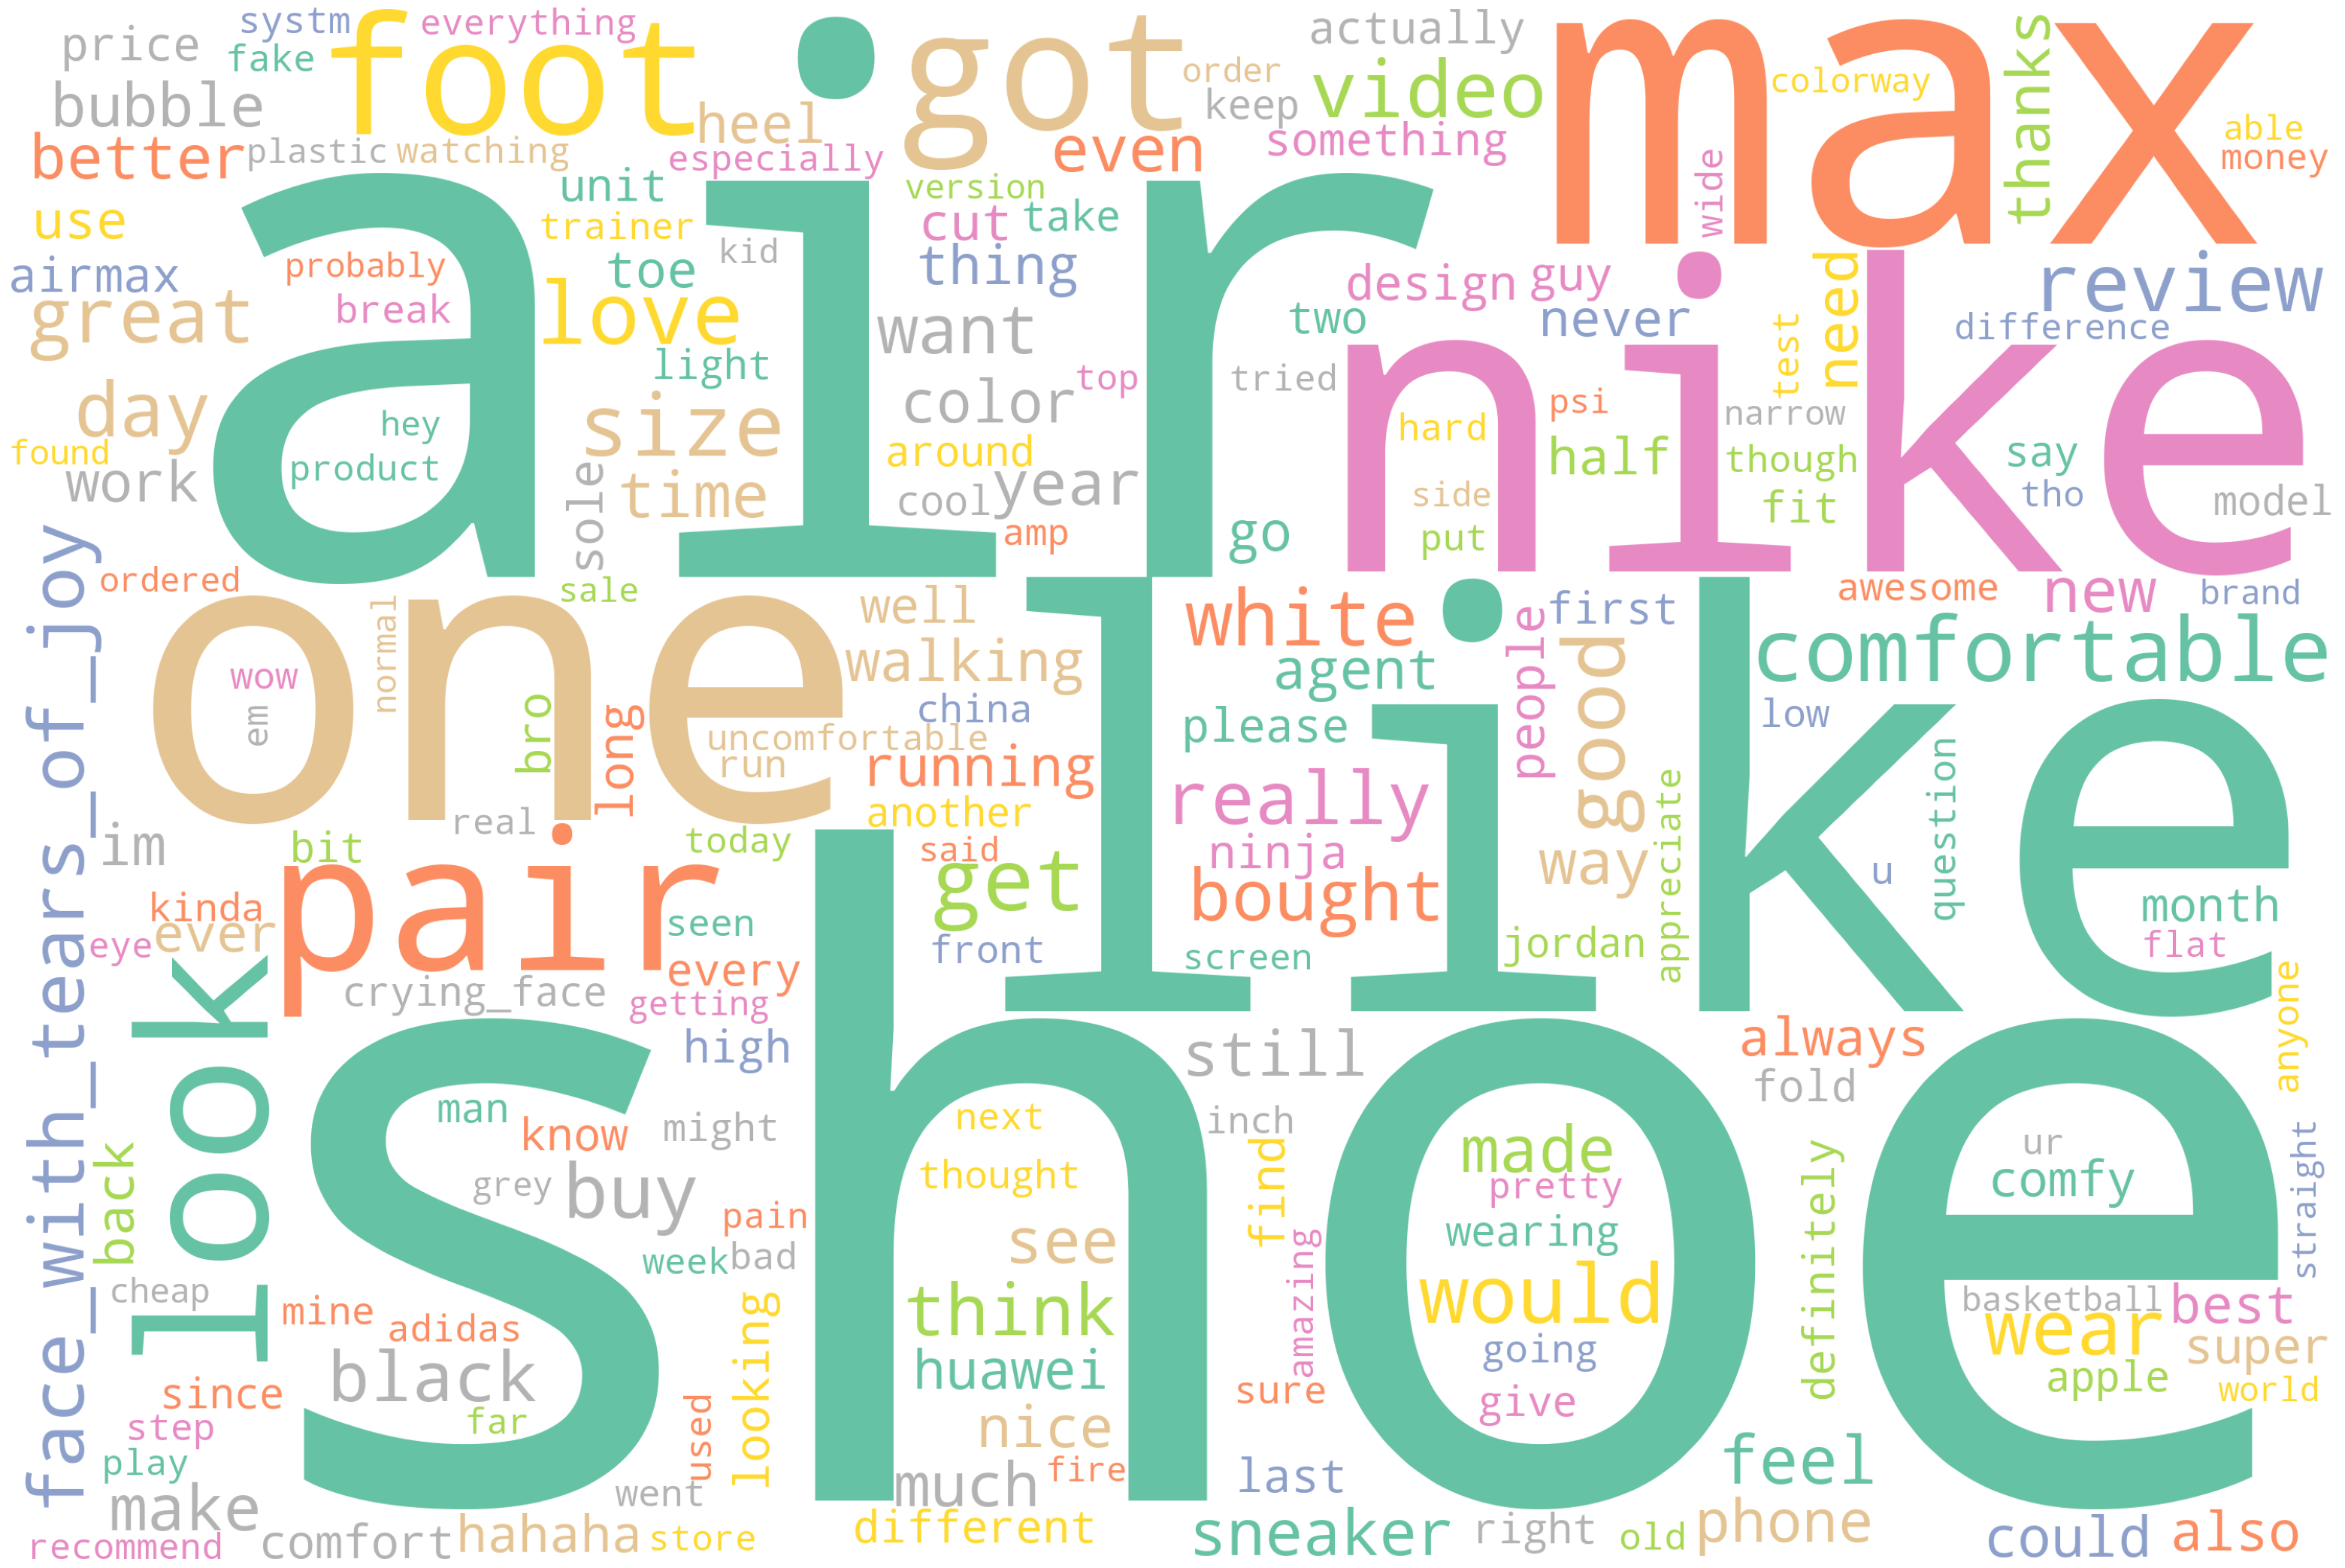

In [38]:
vocabulary_pos = pd.DataFrame(np.concatenate(df['text_filtered'].values), columns=['words'])

# Generate wordcloud
wordcloud = (WordCloud(width = 3000,
                      height = 2000,
                      random_state=42,
                      background_color='white',
                      colormap='Set2',
                      collocations=False)
            .generate_from_frequencies(
                vocabulary_pos.groupby('words').size().sort_values(ascending=False).to_dict()
              )
            )
# Plot
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off");

# Classifying Sentiment<a class="anchor" id="fourth-bullet"></a>

In this step generally we could train a traditional Machine Learning model to tag each comment as "positive", "negative" or "neutral" based on their sentiment, but we don't have a previously treated dataset and most importantly we don't have a labeled target (needed in order to train a supervised model). One of the biggest advantages of LLMs such as OpenAI's ChatGPT is the ability to understand and classify text without a training dataset. That's why I opted to apply a LLM directly to classify the comments.

In [39]:
# function to classify comment sentiments and create a summarization for each video
def analyze_comments(search_query, video_title, comments, api_key):
    # prompts
    prompt_sistema = f"""You are a marketing agent specialized in determining whether a video comments' content has a POSITIVE,
    a NEUTRAL or a NEGATIVE sentiment regarding the subject "{search_query}". After reading all comments, you shall return one
    of the three sentiments: ["POSITIVE", "NEGATIVE", "NEUTRAL"]. Additionally, summarize (max. 5 rows) the most frequent 
    positive and negative aspects and hightlighted features about the subject if applicable and if there are enough comments
    to reinforce those opinions (more than 2 comments). As for the output format to compose your answer, write only the sentiment
    word, a colon, and then the summary text.    
    """
    
    prompt_user=f"Video Title: {video_title}\n"
    for comment in comments:
        prompt_user += f"- {comment}\n"
        
    #print(prompt_sistema)
    #print(prompt_user)

    # initialize client
    cliente = OpenAI(api_key=api_key)
    
    # build response
    response = cliente.chat.completions.create(
        messages = [
            {
                "role":"system",
                "content":prompt_sistema
            },
            {
                "role":"user",
                "content":prompt_user
            }
        ],
        model="gpt-3.5-turbo",
        max_tokens=4096
    )

    result = response.choices[0].message.content
    return result

In [40]:
for video_id in df['video_id'].unique():
    video_title = df[df['video_id']==video_id]['video_title'].values[0]
    comments = df[df['video_id']==video_id]['text_display'].tolist()
    result = analyze_comments(search_query, video_title, comments, openai_key)
    df_videos.loc[df_videos['video_id'] == video_id, 'sentiment'] = result.split(':', 1)[0].strip()
    df_videos.loc[df_videos['video_id'] == video_id, 'summary'] = result.split(':', 1)[1].strip()
    
df_videos

,video_id,video_title,video_description,video_url,relevance,sentiment,summary
0,8y5-UvxoD2E,You’re wrong about Nike Air Max 270,"If you're ever injured in an accident, you can...",https://www.youtube.com/watch?v=8y5-UvxoD2E,RELEVANT,NEGATIVE,The majority of comments express dissatisfacti...
1,5JzIrzXV2vI,Pros &amp; Cons: 2024 Nike Air Max DN Review!,Shop Hibbett City Gear Here! https://bit.ly/37...,https://www.youtube.com/watch?v=5JzIrzXV2vI,RELEVANT,NEUTRAL,"The comments are mainly mixed, expressing both..."
2,p_-2u8x4Re0,Nike Alphafly Next % 2 Shoe Review,,https://www.youtube.com/watch?v=p_-2u8x4Re0,RELEVANT,NEGATIVE,"Price is highlighted as a negative aspect, wit..."
3,P2YQHLY8TGw,Nike Air Max 270 Review Black and White,The Nike Air Max 270 was originally released i...,https://www.youtube.com/watch?v=P2YQHLY8TGw,RELEVANT,NEGATIVE,The most frequent negative aspect mentioned in...
4,xGM6g7HTInU,Nike Air More Uptempo Low,Shop POIZON here!! #ad #poizon Use my code [TE...,https://www.youtube.com/watch?v=xGM6g7HTInU,RELEVANT,NEUTRAL,There are mixed opinions on the Nike Air More ...
5,xxrXtdVyn34,Nike Doesn&#39;t Know What&#39;s Inside Their ...,Buy some Rose anvil leather goods that EVERYBO...,https://www.youtube.com/watch?v=xxrXtdVyn34,RELEVANT,NEGATIVE,Some viewers expressed dissatisfaction with th...
6,4iv34wHa8Jk,Nike Air Max 97 White Review: Not What I Expec...,"Description In this video, we review the Air M...",https://www.youtube.com/watch?v=4iv34wHa8Jk,RELEVANT,NEGATIVE,The most frequent negative aspect mentioned in...
7,K-HoJUGc4XM,Nike Air Deldon Biggest Pros And Cons ( Perfor...,Grab a pair at Nike: https://geni.us/deldon FR...,https://www.youtube.com/watch?v=K-HoJUGc4XM,RELEVANT,NEUTRAL,"The comments include a mix of questions, thank..."
8,X1ayLlbBtrg,Nike Jordan 3 Retro Cement Grey | Unboxing &am...,,https://www.youtube.com/watch?v=X1ayLlbBtrg,RELEVANT,NaN,NaN
9,wKEF7-LNhSo,BEST AIR MAX UNDER £100!? Nike Air Max &quot;S...,Nike Air Max SYSTM DM9537-001 https://tidd.ly/...,https://www.youtube.com/watch?v=wKEF7-LNhSo,RELEVANT,NEUTRAL\n\nPositive Aspects,1. Comfortable for all-day wear\n2. Good value...


At last, we can generate a final summary based on the individual summary texts from each video. The function can be written like such:

In [41]:
def generate_final_summary(search_query, sentiment_list, summary_list, api_key):
    prompt_sistema = f"""You are a marketing agent specialized in summarizing comments and reviews about products and topics.
    You will be given a list of multiple sentiment words (being POSITIVE, NEGATIVE or NEUTRAL), and a list of multiple text 
    excerpts, regarding the regarding the topic "{search_query}". Please provide an overall sentiment, returning only one
    of the three sentiments: ["POSITIVE", "NEGATIVE", "NEUTRAL"], and a single summary (max. 10 rows) based on all the
    provided summaries. In this summary, despite the predominant sentiment, summarize the positive aspects and the negative ones. 
    As for the output format to compose you answer, write: "OVERALL SENTIMENT: ", followed by the predominant sentiment word, 
    then the summary text with the positive and negative aspects.
    """
    prompt_user=f"Sentiment list: {sentiment_list}\nSummary list: {summary_list}"
   
    # initialize client
    cliente = OpenAI(api_key=api_key)
    
    # build response
    response = cliente.chat.completions.create(
        messages = [
            {
                "role":"system",
                "content":prompt_sistema
            },
            {
                "role":"user",
                "content":prompt_user
            }
        ],
        model="gpt-3.5-turbo",
        max_tokens=4096
    )

    result = response.choices[0].message.content
    return result

In [42]:
result = generate_final_summary(search_query, df_videos.sentiment.tolist(), df_videos.summary.tolist(), openai_key)

In [43]:
print(result)

OVERALL SENTIMENT: NEGATIVE

Summary:
The majority of comments regarding the Nike Air review express dissatisfaction with the comfort and durability of the shoes. Users highlight issues such as poor durability, discomfort, tight fit, heel drop design, and lack of cushioning. Price is also a negative aspect, with comments mentioning the inability to afford the shoes and labeling them as a rip off. Some positive aspects include appreciation for the style and looks of the Nike Air shoes, as well as the relief from foot pain they provide for some users. However, the overall sentiment remains negative due to the prevalent criticism of the comfort and durability issues.


### Final tests
Testing with another search topic:

C:\Users\VT418741\AppData\Local\Temp\ipykernel_28888\1959997261.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_filtered'] = df['text_display'].apply(lambda x: preprocessing(x))
C:\Users\VT418741\AppData\Local\Temp\ipykernel_28888\1959997261.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_joined'] = df['text_filtered'].apply(lambda x: ' '.join(x))


OVERALL SENTIMENT: NEGATIVE
Summary: 
Positive Aspects:
- Some players praise the beautiful open world, Zelda-esque elements, and amount of content provided for the price.
- Players appreciate the challenge and unique gameplay experience offered by FromSoftware games.
- New weapons introduced in the DLC are fun to use with unique features like guard counters.
- The DLC is highly praised for its difficulty level, verticality, world design, bosses, and NPCs.
- Some viewers mention enjoying the new weapon types, the interconnected map reminiscent of Dark Souls 1, and the cyberpunk vibe of the game.

Negative Aspects:
- Criticisms include the DLC feeling rushed in terms of content, lack of enemies and loot in certain areas, and high difficulty.
- Disappointment with lack of replayability, recycled content, and empty areas in the DLC.
- Complaints about the repetitive gameplay mechanics, lore inconsistencies, disappointing final boss, and the necessity to find seeds to power up in the game.

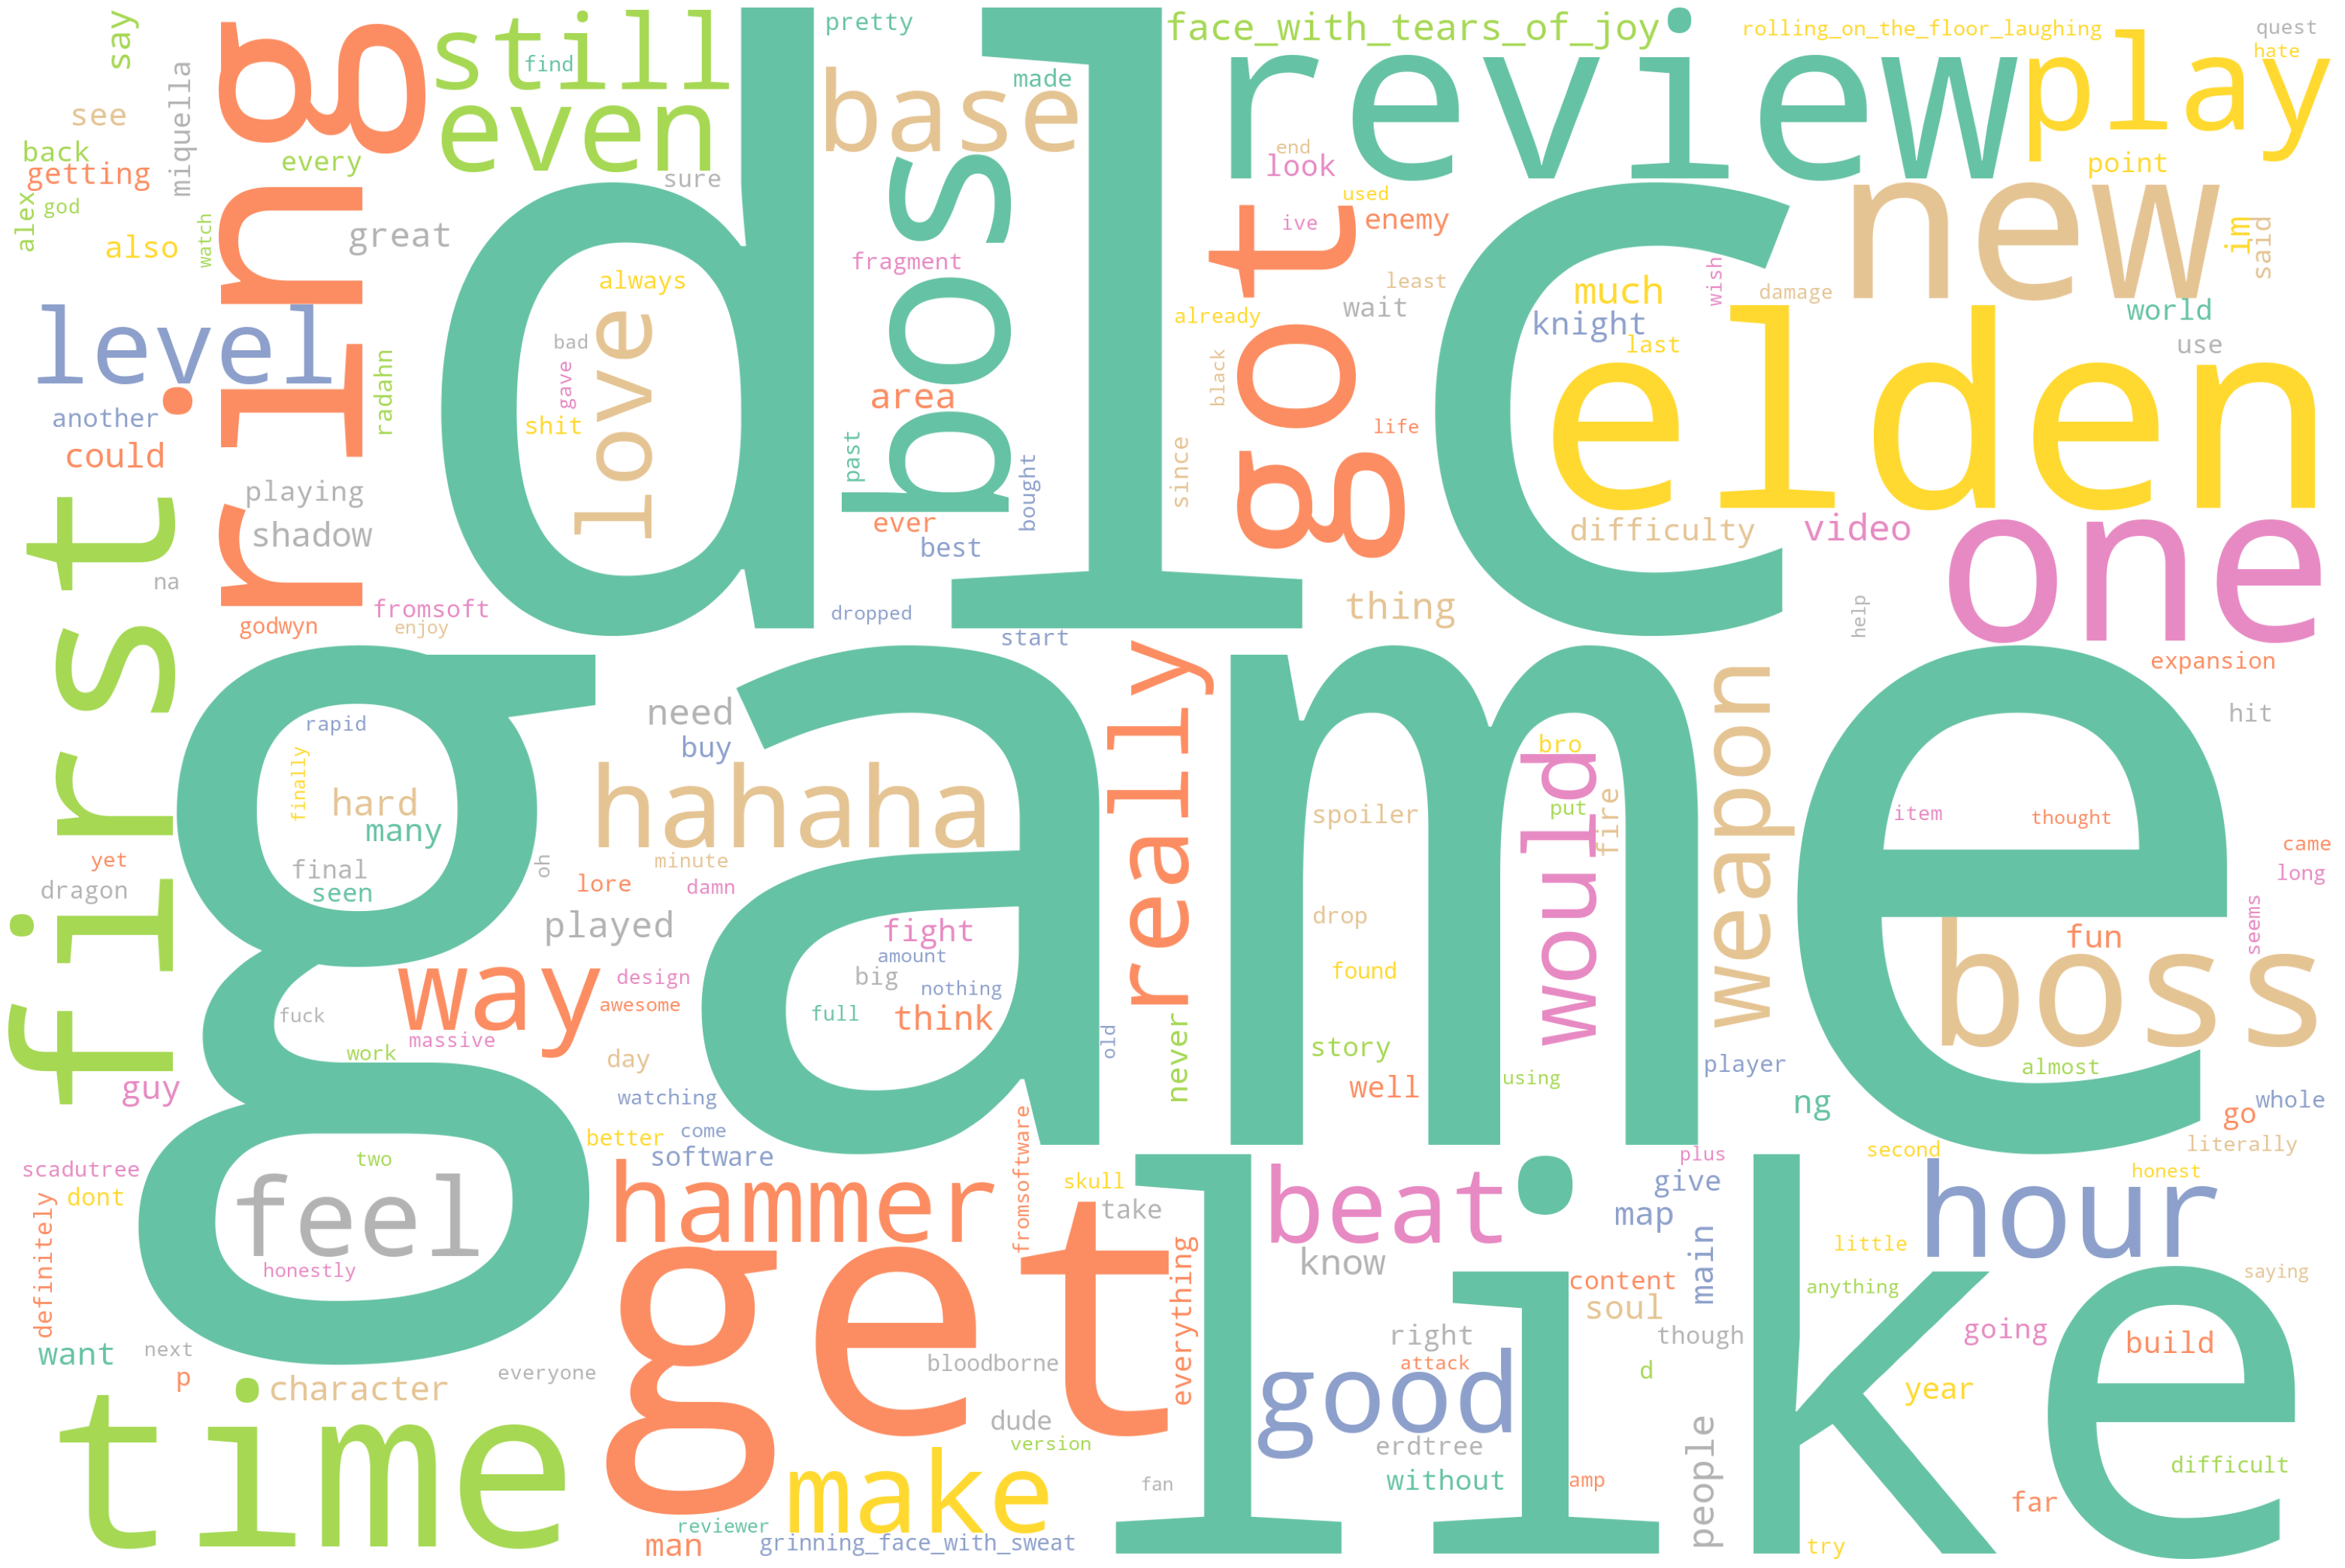

In [44]:
# search for a product
search_query = "shadows of the erdtree review"
df_videos = search_videos(search_query, api_key)

# evaluate relevance
df_videos = classify_video(search_query, df_videos, openai_key)

# add new URLs:
#df_videos = add_videos("https://www.youtube.com/watch?v=hb0j9Qn-KjM", df_videos, api_key)

# get all comments
df_videos_comments = get_video_comments(df_videos)

# applying language detection to each comment
df_videos_comments['language'] = df_videos_comments['text_display'].apply(detect_language)
df = df_videos_comments[df_videos_comments['language'] == 'en']

# pre-processing
stopwords.extend(['href', 'quot', 'br', 'u', 'r', 'lt', 'b'])
stopwords = list(set([unidecode(word) for word in stopwords]))
df['text_filtered'] = df['text_display'].apply(lambda x: preprocessing(x))
df['text_joined'] = df['text_filtered'].apply(lambda x: ' '.join(x))

vocabulary_pos = pd.DataFrame(np.concatenate(df['text_filtered'].values), columns=['words'])

# Generate wordcloud
wordcloud = (WordCloud(width = 3000,
                      height = 2000,
                      random_state=42,
                      background_color='white',
                      colormap='Set2',
                      collocations=False)
            .generate_from_frequencies(
                vocabulary_pos.groupby('words').size().sort_values(ascending=False).to_dict()
              )
            )

# apply sentiment analysis and summarize comments
for video_id in df['video_id'].unique():
    video_title = df[df['video_id']==video_id]['video_title'].values[0]
    comments = df[df['video_id']==video_id]['text_display'].tolist()
    result = analyze_comments(search_query, video_title, comments, openai_key)
    df_videos.loc[df_videos['video_id'] == video_id, 'sentiment'] = result.split(':', 1)[0].strip()
    df_videos.loc[df_videos['video_id'] == video_id, 'summary'] = result.split(':', 1)[1].strip()

# final results
result = generate_final_summary(search_query, df_videos.sentiment.tolist(), df_videos.summary.tolist(), openai_key)
print(result)

# Plot Wordcloud
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off");

In [88]:
print(df_videos['sentiment'].value_counts())
display(df_videos)

sentiment
NEGATIVE    8
POSITIVE    2
Name: count, dtype: int64


,video_id,video_title,video_description,video_url,relevance,sentiment,summary
0,v2tj-b3DfmI,Elden Ring: Shadow of the Erdtree DLC Review,Elden Ring: Shadow of the Erdtree DLC reviewed...,https://www.youtube.com/watch?v=v2tj-b3DfmI,RELEVANT,NEGATIVE,Some users criticize the game for having clunk...
1,zXQ5nDrspvo,Elden Ring: Shadow Of The Erdtree Blew My Mind...,The best thing I can say on Shadow Of The Erdt...,https://www.youtube.com/watch?v=zXQ5nDrspvo,RELEVANT,NEGATIVE,Some users expressed disappointment with the D...
2,46B1IVjvEks,Elden Ring Shadow of the Erdtree - Rapid Fire ...,Patreon ▻ https://www.patreon.com/AngryJoeShow...,https://www.youtube.com/watch?v=46B1IVjvEks,RELEVANT,NEGATIVE,The commenters express frustration about the d...
3,JCysFRlTN20,Shadow of the Erdtree Review - Like a Long Los...,Thanks to Bandai Namco for a review code for S...,https://www.youtube.com/watch?v=JCysFRlTN20,RELEVANT,NEGATIVE,Some players expressed disappointment with the...
4,0sOUwHFXad4,ELDEN RING: Shadow of the Erdtree DLC Review -...,"Back in 2022, FromSoftware revolutionized open...",https://www.youtube.com/watch?v=0sOUwHFXad4,RELEVANT,POSITIVE,"The DLC is described as ""ABSOLUTELY STUNNING"" ..."
5,--eCdoJdTOg,"Elden Ring: Shadow Of The Erdtree Review - No,...","Thank you for watching, please subscribe if yo...",https://www.youtube.com/watch?v=--eCdoJdTOg,RELEVANT,NEGATIVE,The comments express disappointment with the l...
6,9FSJvdMy5Tg,Shadow Of The Erdtree IS PEAK: 100 HOUR REVIEW,THE MOST SINCERE AND SPECIAL THANKS TO BANDAI ...,https://www.youtube.com/watch?v=9FSJvdMy5Tg,RELEVANT,POSITIVE,"The DLC is praised for its world design, verti..."
7,zd74u4lIlfk,Elden Ring: Shadow of the Erdtree PS5 Review -...,"FromSoftware's biggest ever expansion, Shadow ...",https://www.youtube.com/watch?v=zd74u4lIlfk,RELEVANT,NEGATIVE,The reviewer is criticized for not showcasing ...
8,8x2Vb8_BfGs,My Brutally HONEST Review for Shadow of the Er...,Like and subscribe if you enjoyed it! Follow m...,https://www.youtube.com/watch?v=8x2Vb8_BfGs,RELEVANT,NEGATIVE,The majority of comments express disappointmen...
9,InhfVKgYwdc,Elden Ring Shadow of the Erdtree - Before You Buy,Elden Ring returns with the massive DLC expans...,https://www.youtube.com/watch?v=InhfVKgYwdc,RELEVANT,NEGATIVE,The most frequent negative aspects mentioned a...


In [91]:
# checking all comments for a specific video

video_id='v2tj-b3DfmI'
video_title = df[df['video_id']==video_id].video_title.values[0]

print(video_title)
print()
for index, row in df[df['video_id']==video_id].iterrows():
    comment = row['text_display']
    print(comment)
    print()

Elden Ring: Shadow of the Erdtree DLC Review

The comments always look different depending on what Game the “fans” decide to D-Ride

Nice. Dlc. <br><br>Time for Demons Souls 2 <br><br>Add flying <br>Beautiful open world <br>Zelda ish <br><br>Another game of the year for from software <br><br>Make it happen.

Big DLC and you totally get your money’s worth for it, but a 9 not a 10 for me. Bloodborne’s The Old Hunters is still king of all DLCs IMO. The time travel, weapons, and unbelievable bosses in that one prove that quality wins over quantity any day.

24902 Margaret Junction

252 Rice Islands

Me who still doesn&#39;t have the dlc and the whole game because of financial trouble 😢

Should you get the original one or the DLC?

I&#39;ve never played elden ring. What are some tips? Starting tonight

It’s great that elder ring is finally over it’s time for get excited for the next game

This dlc is so big it could be its own game

Goty 2024 is a dlc

&quot;Never got lost&quot;...definitel

In [47]:
df[['video_title', 'text_display']].head(3)

,video_title,text_display
2,Elden Ring: Shadow of the Erdtree DLC Review,The comments always look different depending o...
3,Elden Ring: Shadow of the Erdtree DLC Review,Nice. Dlc. <br><br>Time for Demons Souls 2 <br...
4,Elden Ring: Shadow of the Erdtree DLC Review,Big DLC and you totally get your money’s worth...


In [46]:
# checking sample comments from all videos
for index, row in df.sample(n=10).iterrows():
    comment = row['text_display']
    print(comment)

Lenward, I love it you absolutely deserve that box. The mad lad, love to call you big floppa
The perfect DLC dont exist.... <br><br>- THE DLC: -
the dlc doesn&#39;t work and I payed 40 f*cking dollars
<a href="https://www.youtube.com/watch?v=9FSJvdMy5Tg&amp;t=29">0:29</a> if only people seen the beauty of this dlc instead of “i ran straight to rellana and got my shit kicked in because i had no upgrades. From suck”
Dodge-roll spam, attack, repeat. So bland and boring at this point.
@fightincowboy time stamp 503 that hammer I got first try at church of consolidation 😅
Games like this don‘t deserve a rapid fire review but a standard full review…
why is not dense enought ? how has the dlc an arcane requirement?
&quot;My next build-defining item could be in that red area down there.&quot;<br><br>Narrator: it wasn&#39;t
I still say you should play the games that are the Genesis of from software kings field and the Armored Core games since those games over time is what built the reputation fr

# Deployment in Production<a class="anchor" id="fifth-bullet"></a>
In order to deploy this solution to production, we choose to create a simple Streamlit application, containing a form to input the search subject, then the amount of videos to be searched, and a button to confirm the operation, which will trigger the code and output the final summary and the wordcloud.

The Streamlit app was deployed using Streamlit Community Cloud.

# Results and Future Improvements<a class="anchor" id="sixth-bullet"></a>
- For its first version the app functions well and is capable of providing very detailed answers, even when using an older model from OpenAI
- Some improvements that could be made include letting the user choose between other models available, adding an option to add or remove videos to the list before they are analysed, and tuning some parameters from the LLM in order to make it more or less creative with the answers.
- A smart language detector could also be implemented, so all videos from the same language would be redirected to different pre-processing pipelines.

---

[Back to top](#top-bullet)